In [1]:
%matplotlib inline
%pdb off

Automatic pdb calling has been turned OFF


In [2]:
# numpy = numerical Python, implements arrays (/ matrices)
import numpy as np

# scipy = scientific Python, implements operations on arrays / matrices
import scipy as sp
# linalg = linear algebra, implements eigenvalues, matrix inverse, etc
from scipy import linalg as la
# optimize = optimization, root finding, etc
from scipy import optimize as op

# produce matlab-style plots
import matplotlib as mpl
# increase font size on plots
mpl.rc('font',**{'size':18})

import matplotlib.pyplot as plt
%matplotlib inline
# symbolic computation, i.e. computer algebra (like Mathematica, Wolfram Alpha)
import sympy as sym

In [3]:
# os = operating system; access OS-level commands
# e.g. create directory, delete file, execute command
# (more platform-independent than "!")
import os

In [4]:
# pip = Python package manager; "!" means "run at system level"
!pip install control
import control as ctrl
# this scipy module implements many of the routines in ctrl
from scipy import signal as sig

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [5]:
def Jacobian(g,y,d=1e-4):
  """
  approximate derivative via finite-central-differences 

  input:
    g - function - g : R^n -> R^m
    y - n array
    (optional)
    d - scalar - finite differences displacement parameter

  output:
    Dg(y) - m x n - approximation of Jacobian of g at y
  """
  # given $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
  # $$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
  e = np.identity(len(y))
  Dyg = []
  for j in range(len(y)):
      Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
  return np.array(Dyg).T

def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(x,u) 

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

In [6]:
#define global variables
#mass
m=1

#moment of inertia
I = 0.01

#Earth's Gravitational Constant
g = 9.81

#coefficient of translational frictional drag
beta = .1

In [7]:
#define equilibrium points
tau_r = 9.81/2
tau_l = tau_r
tau_e = np.array([tau_l,tau_r])
q_e = np.array([10,0,2,0,0,0])

In [8]:
#define nonlinear functions

def f_NL(t,x,tau):
    theta,d_q_theta = x[4:]
    d_d_q_theta = (tau[1]-tau[0])/I
    h,dh = x[0:2]
    d_d_qh = ((tau[0]+tau[1])*np.sin(theta)-beta*dh)/m
    v,dv = x[2:4]
    d_dv = (-m*g+(tau[0]+tau[1])*np.cos(theta)-beta*dv)/m
    return np.array([dh,d_d_qh,dv,d_dv,d_q_theta,d_d_q_theta])

def h_NL(t,x,tau):
    return np.array([x[0],x[2],x[4]])

In [9]:
#linearize the statespace

A = Jacobian(lambda x:f_NL(0,x,tau_e),q_e)
B = Jacobian(lambda tauu:f_NL(0,q_e,tauu),tau_e)
C = Jacobian(lambda x: h_NL(0,x,tau_e),q_e)
D = Jacobian(lambda tauu:h_NL(0,q_e,tauu),tau_e)
print(A)
print(B)
print(C)
print(D)

[[ 0.          1.          0.          0.          0.          0.        ]
 [ 0.         -0.1         0.          0.          9.80999998  0.        ]
 [ 0.          0.          0.          1.          0.          0.        ]
 [ 0.          0.          0.         -0.1         0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]
[[   0.    0.]
 [   0.    0.]
 [   0.    0.]
 [   1.    1.]
 [   0.    0.]
 [-100.  100.]]
[[1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]
[[0. 0.]
 [0. 0.]
 [0. 0.]]


In [10]:
#define LTI function

def f_LTI(t,x,tau):
    return np.matmul(A,x)+np.matmul(B,tau)

In [11]:
#define input functions and run the simulations
def u(t):
    return np.array([4.905,4.905])
def u_zero(t):
    return np.array([0,0])
t_,x_ = numerical_simulation(f_LTI,5,np.array([q_e[0]+.5,q_e[1],q_e[2]+.5,q_e[3]+.1,q_e[4]+.01,q_e[5]+.01]),ut=u_zero)
t_,x_nl = numerical_simulation(f_NL,5,np.array([q_e[0]+.5,q_e[1],q_e[2]+.5,q_e[3]+.1,q_e[4]+.01,q_e[5]+.01]),ut=u)


C:\Users\andre\Miniconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


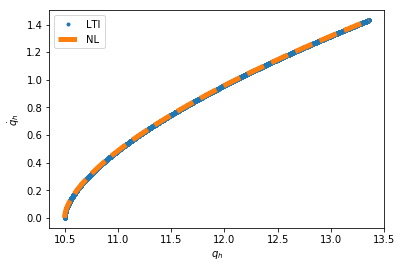

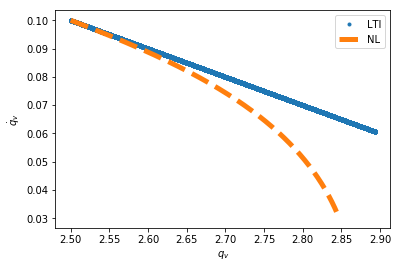

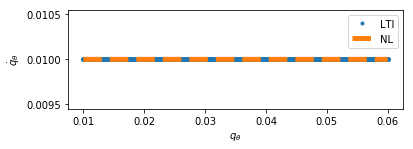

In [12]:
#plot our graphs for lti and nonlinear
plt.figure(1)
plt.plot(x_[:,0],x_[:,1],'.')
plt.plot(x_nl[:,0],x_nl[:,1],'--',linewidth=5)
plt.xlabel(r"$ q_h$")
plt.ylabel(r"$\dot q_h$")
plt.legend([r"LTI",r"NL"])
plt.figure(2)
plt.plot(x_[:,2],x_[:,3],'.')
plt.plot(x_nl[:,2],x_nl[:,3],'--',linewidth=5)
plt.xlabel(r"$ q_v$")
plt.ylabel(r"$\dot q_v$")
plt.legend([r"LTI",r"NL"])
plt.figure(3)
plt.subplot(2,1,1)
plt.plot(x_[:,4],x_[:,5],'.')
plt.subplot(2,1,1)
plt.plot(x_nl[:,4],x_nl[:,5],'--',linewidth=5)
plt.xlabel(r"$ q_\theta$")
plt.ylabel(r"$\dot q_\theta$")
plt.legend([r"LTI",r"NL"])


In [13]:
#compute K matrix for controller

stable = True
marginally = False
eig_vals = la.eig(A)[0]
print("EigenValues: "+ str(eig_vals))
for i in np.real(la.eig(A)[0]):
    if i>0:
        stable = False
        break
    elif i == 0:
        stable = False
        marginally = True
        break

if(stable):
    print("stable")

else:
    if marginally is True:
        print("System is marginally stable")
    else:
        print("System is not stable")
    K = ctrl.place(A,B,[-1.5+.26j,-1.5-.26j,-1.51+.76j,-1.51-.76j,-1.51-.57j,-1.51+.57j])


EigenValues: [ 0. +0.j -0.1+0.j  0. +0.j -0.1+0.j  0. +0.j  0. +0.j]
System is marginally stable


In [14]:
#define our controller
def controller(t,x,tau):
    return np.matmul(A-np.matmul(B,K),x)+np.matmul(B,tau)

In [15]:
#run simulation for the controller

t_,x_,u_ = numerical_simulation(controller,8,np.array([q_e[0]+2,q_e[1]+1,q_e[2]+2,q_e[3]+1,0.1,0]),ut=lambda t:np.array([0,0]),return_u=True)

Text(0,0.5,'$\\dot q_\\theta$')

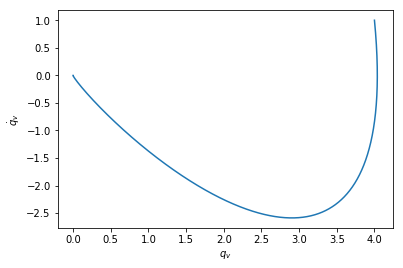

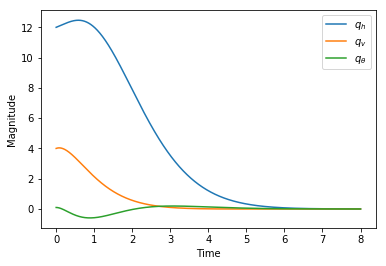

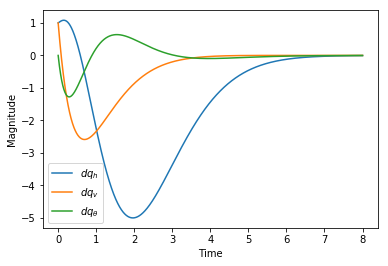

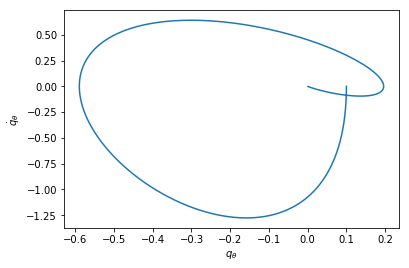

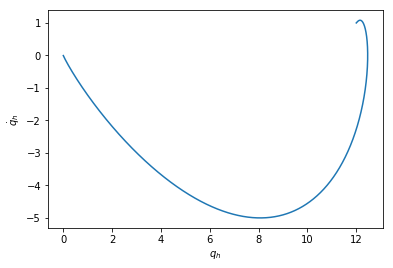

In [16]:
#plot our controller plots
plt.figure(1)
plt.plot(t_,x_[:,0])
plt.plot(t_,x_[:,2])
plt.plot(t_,x_[:,4])
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.legend([r"$ q_h$",r"$ q_v$",r"$ q_\theta$"])

plt.figure(2)
plt.plot(t_,x_[:,1])
plt.plot(t_,x_[:,3])
plt.plot(t_,x_[:,5])
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.legend([r"$ dq_h$",r"$ dq_v$",r"$ dq_\theta$"])

plt.figure(7)
plt.plot(x_[:,0],x_[:,1])
plt.xlabel(r"$ q_h$")
plt.ylabel(r"$\dot q_h$")
plt.figure(8)
plt.plot(x_[:,2],x_[:,3])
plt.xlabel(r"$ q_v$")
plt.ylabel(r"$\dot q_v$")
plt.figure(9)
plt.plot(x_[:,4],x_[:,5])
plt.xlabel(r"$ q_\theta$")
plt.ylabel(r"$\dot q_\theta$")

In [17]:
#place poles for observer

L=ctrl.place(A.T,C.T,np.array([-5,-5.5,-5.4,-5.3,-5.2,-5.1])).T

In [18]:
#error function

def f_error(t,x,u):
    return np.matmul(A-np.matmul(L,C),x)

#run simulation
t,x_ = numerical_simulation(f_error,5,np.array([q_e[0]+2,q_e[1]+1,q_e[2]+2,q_e[3]+1,0.1,0]),ut=u)

Text(0,0.5,'$\\dot e_{q_\\theta}$')

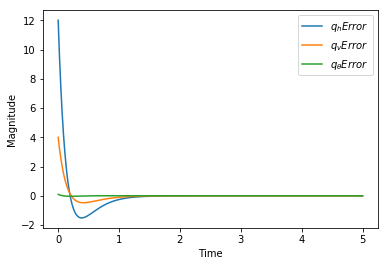

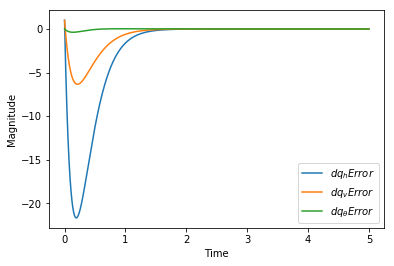

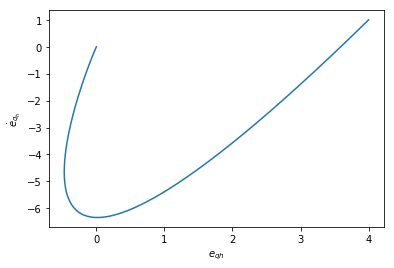

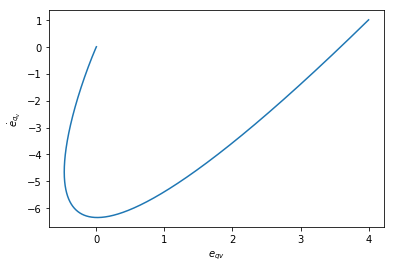

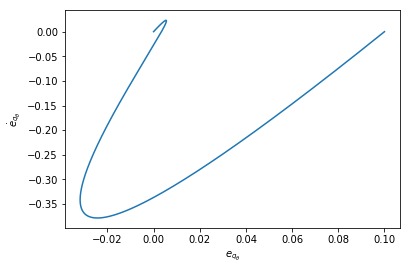

In [19]:
#plot the error

error_h,d_error_h,error_v,d_error_v,error_theta,d_error_theta = x_.T

plt.figure(1)
plt.plot(t,error_h)
plt.plot(t,error_v)
plt.plot(t,error_theta)
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.legend([r"$q_h Error$",r"$q_v Error$",r"$q_\theta Error$"])

plt.figure(2)
plt.plot(t,d_error_h)
plt.plot(t,d_error_v)
plt.plot(t,d_error_theta)
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.legend([r"$dq_h Error$",r"$dq_v Error$",r"$dq_\theta Error$"])

plt.figure(3)
plt.plot(error_v,d_error_v)
plt.xlabel(r"$e_{qh}$")
plt.ylabel(r"$\dot e_{q_h}$")
plt.figure(6)
plt.plot(error_v,d_error_v)
plt.xlabel(r"$e_{qv}$")
plt.ylabel(r"$\dot e_{q_v}$")
plt.figure(9)
plt.plot(error_theta,d_error_theta)
plt.xlabel(r"$e_{q_\theta}$")
plt.ylabel(r"$\dot e_{q_\theta}$")

In [20]:
#define full state feedback system

def full_state(t,x,u):
    D=np.zeros([12,12])
    D[0:6,0:6] = A-np.matmul(B,K)
    D[0:6,6:12] = np.matmul(B,K)
    D[6:12,6:12] = A-np.matmul(L,C)
    return np.matmul(D, x)

#simulate full-state system
t_,x_ = numerical_simulation(full_state, 8,np.array([q_e[0]+2,q_e[1]+1,q_e[2]+2,q_e[3]+1,0.1,0,10,10.1,10.1,10.1,10.1,10.1]),ut=u)

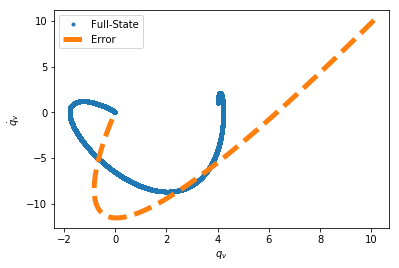

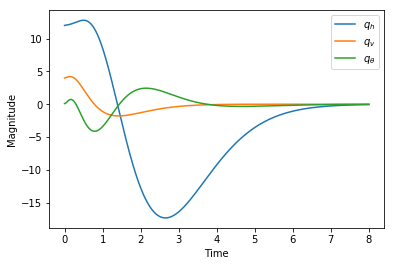

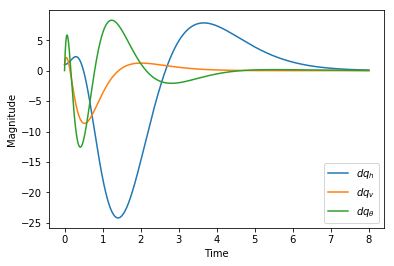

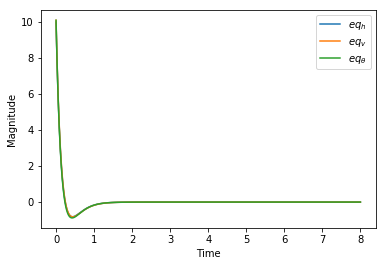

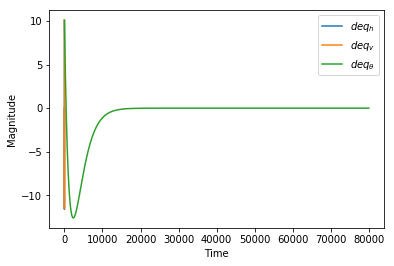

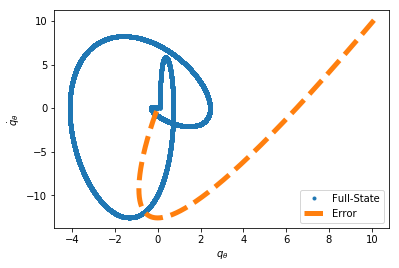

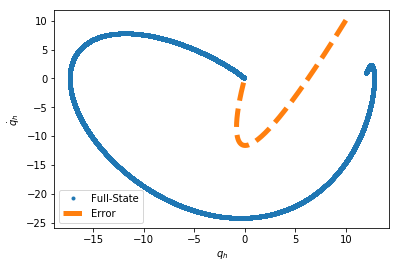

In [21]:
#plot the full-state system

h_,dh_,v_,dv_,theta_,dtheta_,eh,deh,ev,dev,etheta,detheta = x_.T

plt.figure(1)
plt.plot(t_,h_)
plt.plot(t_,v_)
plt.plot(t_,theta_)
plt.legend([r"$q_h$",r"$q_v$",r"$q_\theta$"])
plt.xlabel("Time")
plt.ylabel("Magnitude")

plt.figure(2)
plt.plot(t_,dh_)
plt.plot(t_,dv_)
plt.plot(t_,dtheta_)
plt.legend([r"$dq_h$",r"$dq_v$",r"$dq_\theta$"])
plt.xlabel("Time")
plt.ylabel("Magnitude")

plt.figure(3)
plt.plot(t_,eh)
plt.plot(t_,ev)
plt.plot(t_,etheta)
plt.legend([r"$e q_h$",r"$e q_v$",r"$e q_\theta$"])
plt.xlabel("Time")
plt.ylabel("Magnitude")

plt.figure(4)
plt.plot(t_,deh)
plt.plot(t_,dev)
plt.plot(detheta)
plt.legend([r"$de q_h$",r"$de q_v$",r"$de q_\theta$"])
plt.xlabel("Time")
plt.ylabel("Magnitude")

plt.figure(15)
plt.plot(h_,dh_,'.')
plt.plot(eh,deh,'--',linewidth=5)
plt.xlabel(r"$ q_h$")
plt.ylabel(r"$\dot q_h$")
plt.legend([r"Full-State",r"Error"])
plt.figure(16)
plt.plot(v_,dv_,'.')
plt.plot(ev,dev,'--',linewidth=5)
plt.xlabel(r"$ q_v$")
plt.ylabel(r"$\dot q_v$")
plt.legend([r"Full-State",r"Error"])
plt.figure(17)
plt.plot(theta_,dtheta_,'.')
plt.plot(etheta,detheta,'--',linewidth=5)
plt.xlabel(r"$ q_\theta$")
plt.ylabel(r"$\dot q_\theta$")
plt.legend([r"Full-State",r"Error"])

In [22]:
#set equilibrium points

y_e = np.array([q_e[0],q_e[2],q_e[4]])
u_e = np.array([4.905,4.905])

# vector field
def f_cl(t,z,u): 
  
    # extract controlled system and observer system state from full system state
    x,xi_hat = z[:6],z[6:]

    # compute control input using observer state
    mu = -np.dot(xi_hat,K.T)
    u = mu + u_e 

    # output from controlled system and observer system
    y = h_NL(t,x,u) - y_e
    eta_hat = np.dot(xi_hat,C.T) #+ np.dot(mu,D.T)

    # dynamics of controlled system and observer system
    dx = f_NL(t,x,u)
    dxi_hat = np.dot(xi_hat,A.T) - np.dot(xi_hat,np.dot(K.T, B.T)) + np.dot((y-eta_hat),L.T)

    # combine dynamics of controlled system and observer system
    dz = np.hstack((dx,dxi_hat))

    return dz

t_,x_ = numerical_simulation(f_cl, 8,np.array([q_e[0]+2,q_e[1]+1,q_e[2]+2,q_e[3]+1,0.1,0,q_e[0]+.1,q_e[1]+.1,q_e[2]+.1,q_e[3]+.1,q_e[4]+0.01,0]),ut=u)

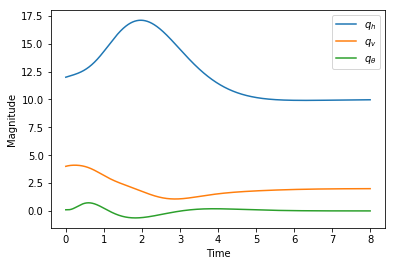

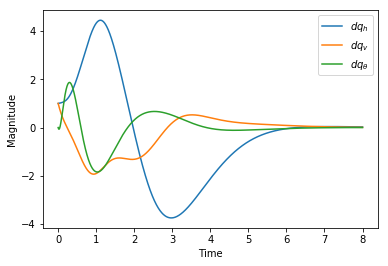

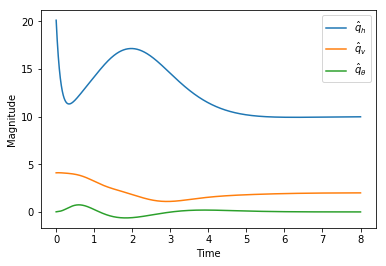

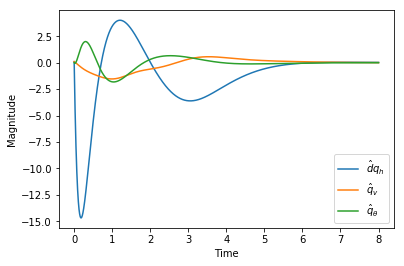

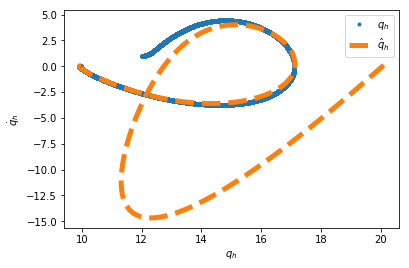

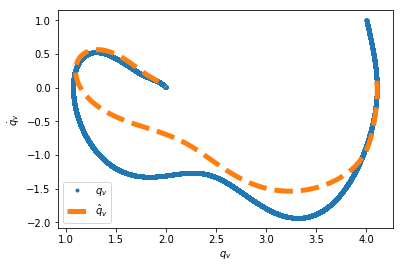

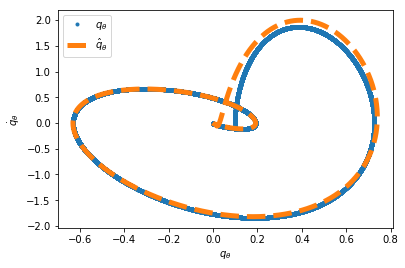

In [23]:
#plot nonlinear closed loop feedback system
h_,dh_,v_,dv_,theta_,dtheta_,h_hat,dh_hat,v_hat,dv_hat,theta_hat,dtheta_hat = x_.T

plt.figure(1)
plt.plot(t_,h_)
plt.plot(t_,v_)
plt.plot(t_,theta_)
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.legend([r"$ q_h$",r"$q_v$",r"$q_\theta$"])

plt.figure(2)
plt.plot(t_,dh_)
plt.plot(t_,dv_)
plt.plot(t_,dtheta_)
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.legend([r"$ dq_h$",r"$dq_v$",r"$dq_\theta$"])

plt.figure(3)
plt.plot(t_,h_hat+q_e[0])
plt.plot(t_,v_hat+q_e[2])
plt.plot(t_,theta_hat+q_e[4])
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.legend([r"$ \hat q_h$",r"$\hat q_v$",r"$\hat q_\theta$"])

plt.figure(4)
plt.plot(t_,dh_hat+q_e[1])
plt.plot(t_,dv_hat+q_e[3])
plt.plot(t_,dtheta_hat+q_e[5])
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.legend([r"$\hat dq_h$",r"$\hat q_v$",r"$\hat q_\theta$"])

plt.figure(7)
plt.plot(h_,dh_,'.')
plt.plot(h_hat+q_e[0],dh_hat+q_e[1],'--',linewidth=5)
plt.xlabel(r"$ q_h$")
plt.ylabel(r"$\dot q_h$")
plt.legend([r"$ q_h$",r"$\hat q_h$"])

plt.figure(8)
plt.plot(v_,dv_,'.')
plt.plot(v_hat+q_e[2],dv_hat+q_e[3],'--',linewidth=5)
plt.xlabel(r"$ q_v$")
plt.ylabel(r"$\dot q_v$")
plt.legend([r"$ q_v$",r"$\hat q_v$"])

plt.figure(9)
plt.plot(theta_,dtheta_,'.')
plt.plot(theta_hat+q_e[4],dtheta_hat+q_e[5],'--',linewidth=5)
plt.xlabel(r"$ q_\theta$")
plt.ylabel(r"$\dot q_\theta$")
plt.legend([r"$ q_\theta$",r"$\hat q_\theta$"])


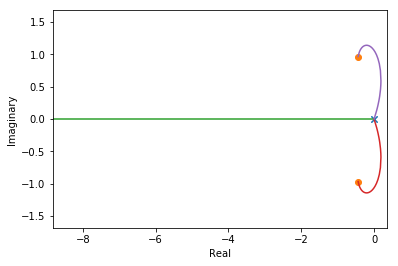

In [24]:
#plot root locus using PID control
kp=.007
kd=.008
ki = .009
tf_rotational = ctrl.tf([1],[I,0,0])
tf_C = ctrl.tf([kd,kp,ki],[1,0])
loop = ctrl.tf(tf_rotational*tf_C)
locus = ctrl.root_locus(loop)

C:\Users\andre\Miniconda3\lib\site-packages\control\xferfcn.py:571: RuntimeWarning: divide by zero encountered in true_divide
  polyval(self.den[i][j], slist))
C:\Users\andre\Miniconda3\lib\site-packages\control\xferfcn.py:571: RuntimeWarning: invalid value encountered in true_divide
  polyval(self.den[i][j], slist))


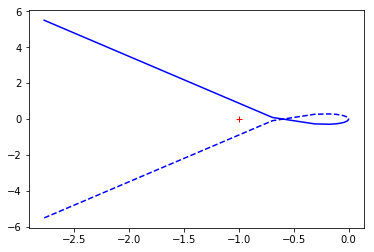

In [25]:
#plot nyquist
nyq = ctrl.nyquist(loop,np.linspace(0,100,200))


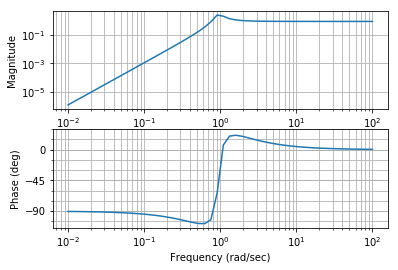

In [26]:
#bode plot
bod = ctrl.bode(1/(1+loop))

In [27]:
#stability margins
ctrl.stability_margins(loop)

(1.6071428571428568,
 -24.751959659499335,
 0.30234397912019684,
 1.0606601717798212,
 0.8779611175004862,
 0.9652524375327568)